In [11]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from openai import OpenAI
import json
import os

os.environ["HACKATHON_API_KEY"] = "rad-69912515feb6baab52a0c1fcf1c3d283cd29b9af1e21ed8117158eb54e338e41-iant"

In [12]:
def load_data(file_path):
    return pd.read_csv(file_path)


def filter_data(df, start_time, frame):
    def generate_range(start_time, frame):
        dtStart = datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S')
        dtDiff = timedelta(hours=frame[0], minutes=frame[1])
        dest = dtStart + dtDiff
        return [start_time, dest.strftime('%Y-%m-%d %H:%M:%S')]
    
    time_range = generate_range(start_time, frame)
    return df[(df["time"] >= time_range[0]) & (df["time"] <= time_range[1])]

def initialize_api_client(api_key):
    return OpenAI(
        base_url="https://hackathon.radiantai.com/insight-ops/openai",
        api_key=api_key
    )


In [13]:
def process_post(post, api_client):
    
    system_prompt = """You are a helpful assistant designed to output JSON.
Your task is to extract information from social media posts or announcements relevant to the Ukraine Russian war and convert it into a graph database.

Here is how the graph database works:
Every object has a title and it has a type, the title indicates the name of the subject: this can be an person or "actor", event, or even concept, just make up a classification that is very standard.
Two objects may be related in some way and this may and in this case, you will add them to the relationships list, try to find fitting relationships between related objects. For example, if you create a relationship between a person and an event you can use the relationship "participated in" or "attended". Or if you have a person and a concept you can use "knows" or "is familiar with". Or if you have two events you can use "happened before" or "happened after". Make up a relationship.
How you will enter it in to the graph database it as follows:
{
  "subjects": [
    [ENTITY_ID: INT, TITLE: STR, TYPE: STR],
    [ENTITY_ID: INT, TITLE: STR, TYPE: STR],
    ...
  ],
  "relationships": [
    [ENTITY_ID_1: INT, RELATIONSHIP: STR, ENTITY_ID_2: INT, PROPERTIES: DICT],
    [ENTITY_ID_1: INT, RELATIONSHIP: STR, ENTITY_ID_2: INT, PROPERTIES: DICT],
    ...
  ]
]
If you can't pair a relationship with a pair of nodes don't add it.
When you find a node or relationship you want to add try to create a generic PROPERTY for it that describes the entity you can also think of it as a label."""

    
    response = api_client.chat.completions.create(
        model="gpt-3.5-turbo-0125",
        response_format={"type": "json_object"},
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": f"Here's the post: {post} \\n Make sure to output in a JSON with the top level keys 'subjects' and 'relationships'"}
        ]
    )
    return json.loads(response.choices[0].message.content)

def extract_graph_data(df, api_client):
    """
    Iterate over a DataFrame of posts, process each one, and accumulate the graph data.
    
    Args:
    df (pandas.DataFrame): DataFrame containing the posts to process.
    api_client (OpenAI.Client): The API client instance.
    
    Returns:
    dict: A dictionary containing accumulated nodes and edges from all posts.
    """
    system_prompt = "Your task is to extract information from social media posts and convert it into a graph database."
    all_data = {'subjects': [], 'relationships': []}  # Initialize structure to hold combined data from all posts
    
    for index, row in df.iterrows():
        
        post_data = process_post(row['translation'], api_client)
        #print(post_data)
        all_data['subjects'].extend(post_data['subjects'])
        all_data['relationships'].extend(post_data['relationships'])
    
    return all_data


In [14]:
api_key = os.environ["HACKATHON_API_KEY"]
df = load_data('data/russia_social_media.csv')


In [15]:
filtered_df = filter_data(df, "2024-03-31 18:00:00", [1, 30]).head(10)
api_client = initialize_api_client(api_key)

In [16]:
structured_data = extract_graph_data(filtered_df, api_client)
structured_data

{'subjects': [[1, 'Oles Buzina', 'person'],
  [2, 'Vladimir Zhirinovsky', 'person'],
  [3, 'Vladimir Solovyov', 'person'],
  [4, 'Duel', 'event'],
  [5, 'socio-political topics', 'concept'],
  [1, 'Russians', 'actor'],
  [2, 'Kharkiv region', 'location'],
  [3, "152-mm self-propelled gun 2C19 'Msta-S'", 'weapon'],
  [4, '14th separate mechanized brigade', 'military unit'],
  [5, 'Prince Roman the Great', 'person'],
  [6, 'Volyn', 'location'],
  [7, 'small drone', 'technology'],
  [1, 'Ukraine', 'actor'],
  [2, 'European Union', 'actor'],
  [3, 'The Telegraph', 'actor'],
  [4, 'extreme right-wing parties', 'actor'],
  [5, 'European Parliament elections', 'event'],
  [1, 'Rabotino area', 'location'],
  [2, 'Hydra stronghold', 'location'],
  [3, 'A.Radov', 'person'],
  [4, 'our guys', 'group'],
  [1, 'No elections', 'Concept'],
  [2, 'No Crimea', 'Concept'],
  [3, 'No Donbass', 'Concept'],
  [4, 'No future', 'Concept'],
  [5, 'crests', 'Actor'],
  [1, 'Republicans', 'actor'],
  [2, 'party

In [18]:
def create_graph(data):
    G = nx.DiGraph()
    for node in data['subjects']:
        node_id, name, node_type = node
        G.add_node(node_id, name = name, node_type = node_type)
        
    for edge in data['relationships']:
        source, relation, target, props = edge
        G.add_edge(source, target, relation=relation)
    return G

def draw_graph(G):
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, node_size=100, node_color='lightblue', alpha=0.6)
    nx.draw_networkx_edges(G, pos, arrowstyle='-|>', arrowsize=5, edge_color='gray', width=2)
    node_labels = {node: G.nodes[node]['name'] for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=12)
    edge_labels = {(u, v): data['relation'] for u, v, data in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
    plt.title('Graph Visualization')
    plt.axis('off')
    plt.show()

In [19]:
G = create_graph(structured_data)

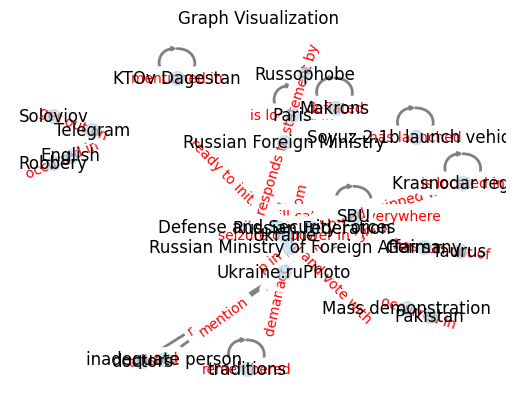

In [20]:
draw_graph(G)

In [21]:
nx.write_gml(G, 'test1.gml')

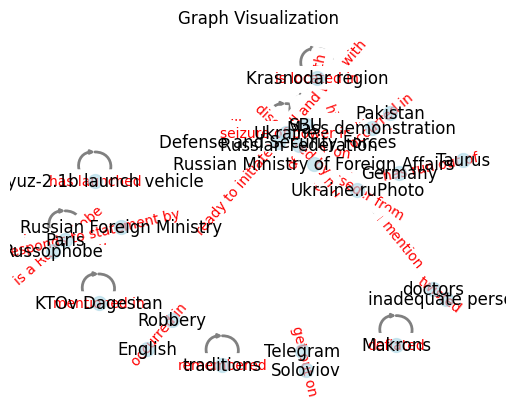

In [22]:
draw_graph(G)

In [23]:
# Display the graph
print("Nodes in the graph:")
print(G.nodes(data=True))

print("Edges in the graph:")
print(G.edges(data=True))

Nodes in the graph:
[(1, {'name': 'Ukraine.ruPhoto', 'node_type': 'actor'}), (2, {'name': 'Russian Ministry of Foreign Affairs', 'node_type': 'actor'}), (3, {'name': 'SBU', 'node_type': 'actor'}), (4, {'name': 'Russian Federation', 'node_type': 'actor'}), (5, {'name': 'Defense and Security Forces', 'node_type': 'actor'}), (6, {'name': 'Ukraine', 'node_type': 'actor'}), (7, {'name': 'Krasnodar region', 'node_type': 'location'}), (8, {'name': 'doctors', 'node_type': 'actor'}), (9, {'name': 'inadequate person', 'node_type': 'actor'}), (10, {'name': 'KTOv Dagestan', 'node_type': 'concept'}), (11, {'name': 'Germany', 'node_type': 'actor'}), (12, {'name': 'Taurus', 'node_type': 'concept'}), (13, {'name': 'Paris', 'node_type': 'location'}), (14, {'name': 'Russophobe', 'node_type': 'concept'}), (15, {'name': 'Russian Foreign Ministry', 'node_type': 'actor'}), (16, {'name': 'traditions', 'node_type': 'concept'}), (17, {'name': 'Soyuz-2.1b launch vehicle', 'node_type': 'concept'}), (18, {'name':